## This is a notebook that integrates the training of two architectrures of NN over the histoloung 600 dataset. It has two differentiated cells for each network architecture. 
## On top, it will implement a search of the best architecture with tunersearch. 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import Sequence
import os
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from keras import layers
from keras import models
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
import mlflow

In [3]:
# Choose the Type of architecture to train


#Architecture = 'EfficientNetB4'
Architecture = 'CNN'

In [4]:
# Define the root directory where your data is stored
root_directory = "dataset_2_final"

# Get the list of subdirectories (categories)
subdirectories = [subdir for subdir in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, subdir))]

# Create lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate through each subdirectory (category)
for label, subdirectory in enumerate(subdirectories):
    # Construct the full path to the subdirectory
    subdirectory_path = os.path.join(root_directory, subdirectory)

    # Get a list of image files in the subdirectory
    image_files = [os.path.join(subdirectory_path, filename) for filename in os.listdir(subdirectory_path) if filename.endswith('.jpg')]  # Adjust the file extension as needed
    
    # Append image paths and labels
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))


# Print the number of images and labels
print("Total images:", len(image_paths))
print("Total labels:", len(labels))

Total images: 494
Total labels: 494


In [6]:
# Here we create a custom data generator that inherits from the Sequence class
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = 4 * len(image_paths)
        self.indices = np.arange(self.num_samples)

    def __len__(self):        

        # I calculate the number of batches
        return int(np.ceil(self.num_samples / self.batch_size))

               

    def load_image(self, image_path):

        #Load the original image using Pillow
        original_image = Image.open(image_path)
        original_image_array = np.array(original_image)

        # Split the original image into 4 pieces
        h, w, c = original_image_array.shape
        h_half, w_half = h // 2, w // 2
       
        image_pieces = [
            original_image_array[:h_half, :w_half],
            original_image_array[:h_half, w_half:],
            original_image_array[h_half:, :w_half],
            original_image_array[h_half:, w_half:]
        ]
        
        # Resize the image pieces and provide the shape of the output
        resized_images = [tf.image.resize(piece, self.image_size) for piece in image_pieces]

        #Shape of resized image list
        #print(np.array(resized_images).shape)
        

    def __getitem__(self, index):

        #This function is called when you call the generator. It generates a batch of indices by slicing
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = []
        batch_labels = []

        # Iterate over indices in the current batch
        for batch_index in batch_indices:

            # Calculate the index of the original image and the piece index within it
            image_index = batch_index // 4   # Divide by 4 to get original image index
            piece_index = batch_index % 4    # Modulus 4 to get piece index

            # Get the image path and original label for the current image
            image_path = self.image_paths[image_index]
            original_label = self.labels[image_index]
            image_pieces = self.load_image(image_path)

            # Load and split the image into pieces
            piece = image_pieces[piece_index]
            batch_images.append(piece)
            batch_labels.append(original_label)


        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels


        
        return resized_images


In [8]:
batch_size = 32

if Architecture == 'EfficientNetB4':
    image_size = (380, 380)  # Adjust the image size based on your model's input requirements

elif Architecture == 'CNN':
    #This image size is close to the largest I can use with this architecture. Ideally, I would like to use  the same size as in the Effnet, to ccompare the two architectures head to head. 
    image_size = (255, 255)


#Make training and validation sets. The test set, I will handle independently in another file
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
#make also a test set off the validation set
val_paths, test_paths, val_labels, test_labels = train_test_split(val_paths, val_labels, test_size=0.5, random_state=42)



# Create data generators for training, validation, and test sets
train_generator = CustomDataGenerator(train_paths, train_labels, batch_size, image_size)
val_generator = CustomDataGenerator(val_paths, val_labels, batch_size, image_size)
test_generator = CustomDataGenerator(test_paths, test_labels, batch_size, image_size)


In [10]:

# Calculate the sizes of the datasets
train_size = len(train_paths)
val_size = len(val_paths)
test_size = len(test_paths)

# Print the sizes
print(f"Training Set Size: {train_size} samples")
print(f"Validation Set Size: {val_size} samples")
print(f"Test Set Size: {test_size} samples")


Training Set Size: 395 samples
Validation Set Size: 49 samples
Test Set Size: 50 samples


In [7]:
if Architecture == 'EfficientNetB4':

    base_model = EfficientNetB4(include_top = False ,weights='imagenet', pooling='avg')

    # Introduce a layer of data augmentation
    data_augmentation = Sequential([
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomContrast(0.2),
        preprocessing.RandomTranslation(0.2, 0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
    ])

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze the last 10 layers in the base model for fine-tuning
    for layer in base_model.layers[-5:]:
        layer.trainable = True

    
    #capa de entradas. 
    entradas = layers.Input((380, 380, 3))

    # Capa de augmentation
    x = data_augmentation(entradas)
    # Pass the augmented images through the base model
    x = base_model(x)
    # Add a dense layer
    x = layers.Dense(256, activation='relu')(x)
    # Add another dense layer
    salidas = layers.Dense(7, activation='softmax')(x)


    model = Model(inputs = entradas, outputs = salidas)
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary()

    
elif Architecture == 'CNN':

    input_shape = (255, 255, 3)

    
    model=models.Sequential()

    model.add(layers.Rescaling(scale = 1./255, offset=0.0, input_shape=input_shape))
    model.add(layers.Input(input_shape))

    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.2))
    model.add(layers.RandomContrast(0.2))
    model.add(layers.RandomTranslation(0.2, 0.2))
    # model.add(layers.RandomHeight(0.2))
    # model.add(layers.RandomWidth(0.2))


    model.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Add flatten layer
    model.add(layers.Flatten())

    # Add dense/dropout layers + activation functions

    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(7, activation = 'softmax'))

    adamop = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(optimizer = adamop, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 255, 255, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 255, 255, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 255, 255, 3)       0

In [8]:
tf.keras.backend.clear_session()

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='auto', verbose = 1)

In [10]:
mlflow.end_run()

In [18]:
# Start an MLflow run
mlflow.start_run()
mlflow.set_experiment('scientific_data')
# Log the name of the dataset
epochs = 120
# Train the model using the custom data generators and the debugging callback
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, shuffle=True, callbacks=[early_stopping])

Epoch 1/120
50/50 [==============================] - 164s 3s/step - loss: 1.6693 - accuracy: 0.3392 - val_loss: 1.8824 - val_accuracy: 0.3005
Epoch 2/120
50/50 [==============================] - 146s 3s/step - loss: 1.8601 - accuracy: 0.3525 - val_loss: 2.2712 - val_accuracy: 0.2121
Epoch 3/120
50/50 [==============================] - 135s 3s/step - loss: 1.7310 - accuracy: 0.3108 - val_loss: 1.8865 - val_accuracy: 0.2879
Epoch 4/120
50/50 [==============================] - 132s 3s/step - loss: 1.6806 - accuracy: 0.3196 - val_loss: 1.8974 - val_accuracy: 0.2753
Epoch 5/120
50/50 [==============================] - 152s 3s/step - loss: 1.6941 - accuracy: 0.3304 - val_loss: 1.8629 - val_accuracy: 0.3283
Epoch 6/120
50/50 [==============================] - 139s 3s/step - loss: 1.7413 - accuracy: 0.3158 - val_loss: 1.9050 - val_accuracy: 0.2828
Epoch 7/120
50/50 [==============================] - 155s 3s/step - loss: 1.6960 - accuracy: 0.3449 - val_loss: 2.0258 - val_accuracy: 0.2929
Epoch 

In [19]:

#Logging
mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)
#mlflow.log_param("parameters", num_params)
#mlflow.log_metric("val_loss", loss)
#mlflow.log_metric("val_accuracy", accuracy)
mlflow.end_run()


In [20]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [22]:
#Guardo el modelo en la última epoch
model.save(folder_date + '/modelo_entrenado.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


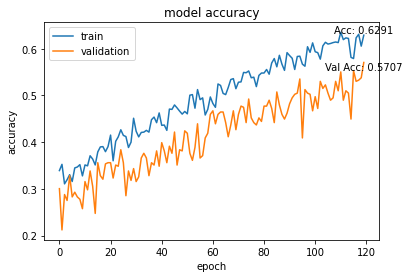

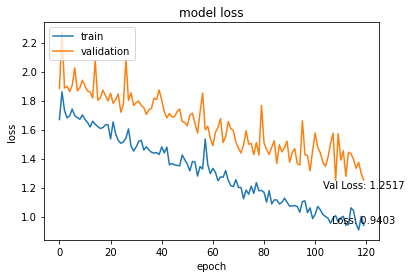

In [23]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()


[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 1, 6, 2, 2, 1, 2, 3, 3, 4, 4, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 5, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 4, 4, 4, 4, 1, 4, 6, 6, 4, 4, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 5, 3, 3, 5, 2, 5, 0, 5, 5, 5, 5, 5, 5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


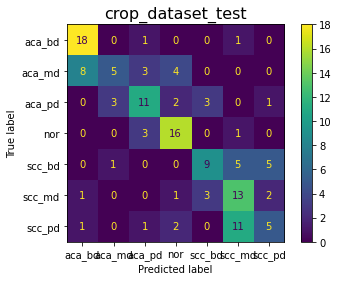

Precision: 0.5459043271655448
Recall: 0.55
Accuracy: 0.55


In [25]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []


#This is only for testing the code. Images are the same!

directory = "crop_dataset_test"


label_mapping = {
    'aca_bd': 0,
    'aca_md': 1,
    'aca_pd': 2,
    'nor' : 3,
    'scc_bd' : 4,
    'scc_md' : 5, 
    'scc_pd' : 6
}

for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)



    #Here I check if the model used was the CNN or the efficientnet. I have to change the input shape accordingly
    if Architecture == 'EfficientNetB4':
        imagen = tf.keras.preprocessing.image.load_img(f, target_size=(380,380))
        
    else:
        #Unificar image size a 380. 255 es un poco arbitrario en la CNN
        imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))

        #El modelo tiene una capa de rescalado, o sea que ya acepta images normales 
        #imagen = np.array(imagen)/255


    
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)




    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca_bd' in filename:
        true_labels.append(0)
    elif 'aca_md' in filename:
        true_labels.append(1)
    elif 'aca_pd' in filename:
        true_labels.append(2)
    elif 'nor' in filename:
        true_labels.append(3)
    elif 'scc_bd' in filename:
        true_labels.append(4)    
    elif 'scc_md' in filename:
        true_labels.append(5)
    elif 'scc_pd' in filename:
        true_labels.append(6)
    
    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)